## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

from dvn.dvn_fcn import DeepVesselNetFCN
from dvn.solver import Solver
from dvn.data_utils import MRAData
from dvn import patchify_unpatchify as pu

torch.set_default_tensor_type('torch.FloatTensor')
# set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## MRA dataset

Text(0.5, 1.0, 'Output image')

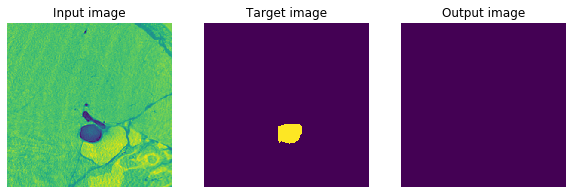

In [4]:
test_MRA = MRAData(root_path="./mra/")
volume, segmentation = test_MRA[0]

model = DeepVesselNetFCN()
model = torch.load("models/deepvesselnet4.model")

model.eval()

patch_size = (1, 84, 84, 84)
stride = (60, 60, 60)

patches = pu.patchify(volume, patch_size, stride)
patch_shape = patches.shape
patches = Variable(patches.view((-1,) + patch_size).cuda().type(torch.cuda.FloatTensor), requires_grad=False)

output = torch.zeros((0, ) + patch_size[1:])

batch_size = 8 # user input
num = int(np.ceil(1.0 * patches.shape[0] / batch_size))

for i in range(num):
    model_output = model.forward(patches[batch_size*i:batch_size*i + batch_size])
    _, preds = torch.max(model_output, 1)
    preds = preds.type(torch.FloatTensor)
    
    output = torch.cat((output, preds), 0) # replace model with your network

new_shape = patch_shape

output = pu.unpatchify(output.view(new_shape), stride, volume.shape, 1)

view_number = 211

plt.figure(figsize = (10, 10))
# inputs
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(volume[0, view_number])
plt.title("Input image")

# target
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(segmentation[0, view_number])
plt.title("Target image")

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(output[0, view_number])
plt.title("Output image")
